# Figure 1 

1. Retinotopic map (phase and sign maps) + boundary
2. Model performance via prediction + noise ceiling distribution
3. Example experiment: 
    a. Matching neurons across days
    b. Confusion matrix
    c. Boxplot nat vs opt (norm)
    d. Histogram nat vs opt (perc)
    e. Example traces
4. Validation summary

## Imports and setup

In [1]:
from utils import *
from plot_params import *
from sklearn.linear_model import LinearRegression
from scipy.stats import mannwhitneyu

In [2]:
save = True
savepath = r'D:\Data\DeepMouse\Figures\Figure1'

## 1. Retinotopic map
From a preprocessed phase and sign map, generate phase + sign map plots

In [3]:
# Plotting functions
def plot_signmap(sign_map, figsize=(6,5)):
    '''Plot sign map'''
    fig, ax = pl.subplots(figsize=figsize, frameon=False)
    ax.imshow(np.fliplr(np.rot90(sign_map)), cmap='bwr', vmin=-1., vmax=1., aspect='equal')
    ax.axis('off')

    return (fig, ax)

def plot_phasemap(phasemap_a, phasemap_e, sign_map, sigma=1, levels=10, ndilate=15, figsize=(10,5), cutoff=0.2, border=True):
    '''Plot phase map as contour plots.'''
    vis_border, patch_border = patch_edge(sign_map, ndilate=ndilate, borderWidth=1, cutoff=cutoff)
    patch_border = np.fliplr(np.rot90(patch_border))
    mask = np.fliplr(np.rot90(gaussian_filter(vis_border.astype(float), sigma=5)))
    mask[mask<0.05] = 0
    phasemap_a = np.fliplr(np.rot90(circular_smoothing(phasemap_a, sigma=sigma)))
    phasemap_e = np.fliplr(np.rot90(circular_smoothing(phasemap_e, sigma=sigma)))

    fig, ax = pl.subplots(ncols=2, figsize=figsize)
    c1 = ax[0].contourf(phasemap_a*mask, cmap='bwr', levels=levels, vmin=-np.pi/2, vmax=np.pi/2, zorder=-99)
    if border: ax[0].imshow(patch_border, cmap='gray', interpolation='None')
    ax[0].axis('off')
    # ax[0].set_title("Azimuth")
    if not border: ax[0].invert_yaxis()

    c2 = ax[1].contourf(phasemap_e*mask, cmap='bwr', levels=levels, vmin=-np.pi/2, vmax=np.pi/2, zorder=-99)
    if border: ax[1].imshow(patch_border, cmap='gray', interpolation='None')
    divider = make_axes_locatable(ax[1])
    ax[1].axis('off')
    # ax[1].set_title("Elevation")
    if not border: ax[1].invert_yaxis()
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(c1, cax=cax, ticks=[-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2])
    # cbar.ax.set_yticklabels(['-π/2', '-π/4', '0', 'π/4', 'π/2'])
    cbar.ax.set_yticklabels(['', '', '', '', ''])

    return (fig, ax)

In [4]:
# Filepath to sign map data
fp_retmap = r'F:\DeepMouse\RT_117\wdf\20230727\wdf'
fp_retmap = r'D:\Projects\Retinotopic-Mapping\Example'

# Load data
phasemap = np.load(os.path.join(fp_retmap, r'analysis_output_fftmaps.npy')) # phase_a, amp_a, phase_e, amp_e, reference
signmap = np.load(os.path.join(fp_retmap, r'analysis_output_signmap.npy'))
phasemap_a, phasemap_e = phasemap[0][10:-10,50:210], phasemap[2][10:-10,50:210]

# Plot parameters
median_size = 15
offset = np.pi*0
sigma = 0.5
levels = 15
ndilate = 15
cutoff=0.2

In [5]:
sign_map = make_signmap(phasemap_a, phasemap_e, offset=offset, median_size=median_size)

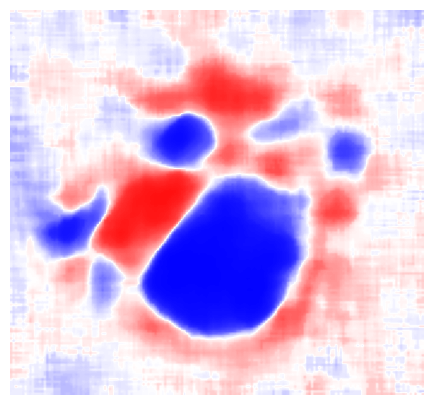

In [6]:
fig1 = plot_signmap(sign_map)
if save: fig1[0].savefig(os.path.join(savepath, 'signmap.pdf'))

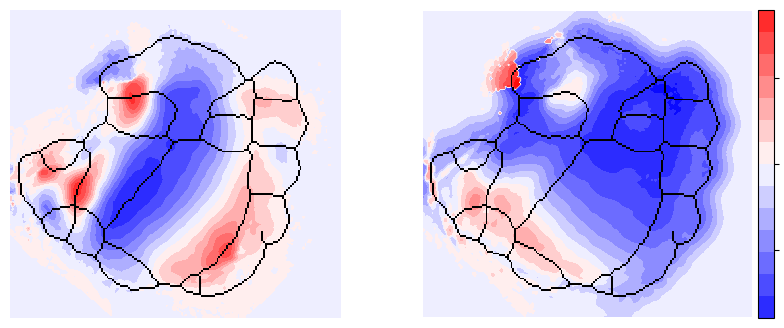

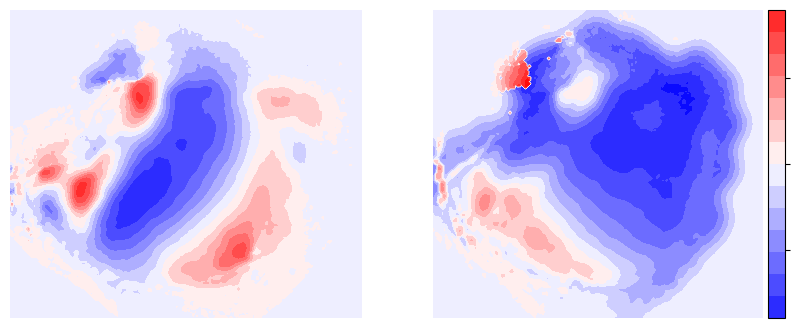

In [7]:
fig21 = plot_phasemap(phasemap_a, phasemap_e, sign_map, sigma=sigma, levels=15, ndilate=ndilate, figsize=(10,4), cutoff=cutoff)
if save: fig21[0].savefig(os.path.join(savepath, 'phasemap.eps'))
fig22 = plot_phasemap(phasemap_a, phasemap_e, sign_map, sigma=sigma, levels=15, ndilate=ndilate, figsize=(10,4), cutoff=cutoff, border=False)
if save: fig22[0].savefig(os.path.join(savepath, 'phasemap_noborder.eps'))

## 2. Model performance

In [8]:
# Plotting functions
def plot_noise_ceiling(data, regions, figsize=(10,5)):
    '''Given a list of noise ceiling distribution, plot the histograms'''
    bins = np.linspace(-0.5, 1, 50)
    fig, axes = pl.subplots(ncols=3, nrows=2, figsize=figsize)
    for i, ax in enumerate(axes.reshape(-1)):
        ax.hist(data[i], bins=bins, color=[.2]*3)
        ax.hist(data[i], bins=bins, color='k', histtype='step', linewidth=1.5)
        line = ax.axvline(0.5, ls='--', color='r')
        # if i == 0: ax.legend([line], ['cutoff'])
        ax.set_title(f"{regions[i]}: {(data[i] > 0.5).sum()}/{data[i].shape[0]}")
        ax.set_xlabel('Response reliability')
        ax.set_ylabel('Count')

    fig.tight_layout()

    return fig, axes

def plot_noise_ceiling_pooled(data, regions, figsize=(6,5)):
    '''Given a list of noise ceiling distribution, plot the pooled histogram'''
    bins = np.linspace(-0.5, 1, 50)
    fig, ax = pl.subplots(figsize=figsize)
    ax.hist(np.concatenate(data), bins=bins, color=[.2]*3)
    ax.hist(np.concatenate(data), bins=bins, color='k', histtype='step', linewidth=1.5)
    line = ax.axvline(0.5, ls='--', color='r')
    ax.set_xlabel('Response reliability')
    ax.set_ylabel('Count')
    # ax.legend([line], ['cutoff'])

    fig.tight_layout()

    return fig, ax

def calculate_prediction(predictions, noise_ceilings, N=1000, size=200):
    '''Given two arrays of model performance and noise ceiling, fit a line without offset to determine ratio. Repeat for subsamples'''
    ratio = []
    model = LinearRegression(fit_intercept=0)
    for i in range(N):
        idx = np.random.choice(range(predictions.shape[0]), size=size, replace=True)
        model.fit(noise_ceilings[idx].reshape(-1,1), predictions[idx].reshape(-1,1))
        ratio.append(model.coef_)
    return np.squeeze(ratio)
        

def plot_prediction(predictions, predictions0, noise_ceilings, regions, figsize=(10,5), normalise=True):
    '''Plot the model performance as pearson r of test stimuli. If normalise=True, normalise prediction to noise ceiling'''
    if normalise: predictions = [predictions[i]/(noise_ceilings[i]) for i in range(len(predictions))]
    if normalise: predictions0 = [predictions0[i]/(noise_ceilings[i]) for i in range(len(predictions0))]
    fig, ax = pl.subplots(figsize=figsize)
    bp1 = ax.boxplot(predictions, showfliers=False, positions=np.arange(1, len(regions)+1)-0.2, widths=0.25, 
                     patch_artist=True, medianprops=dict(color='k'))

    for patch, color in zip(bp1['boxes'], colors):
        patch.set_facecolor(color)

    ax.boxplot(predictions0, showfliers=False, positions=np.arange(1, len(regions)+1)+0.2, widths=0.25, 
               patch_artist=True, medianprops=dict(color='k'), boxprops=dict(facecolor=[.3]*3))

    ax.set_xticks(np.arange(1, len(regions)+1))
    ax.set_xticklabels(regions)
    # ax.set_ylabel('Fraction explainable\nvariance explained')

    return fig, ax

def plot_prediction_bar(explained, explained0, regions, figsize=(10,5)):
    '''Plot the fraction explainable variance explained.'''
    var_explained_mean = np.mean(explained, axis=1)
    var_explained0_mean = np.mean(explained0, axis=1)
    var_explained_std = np.std(explained, axis=1)
    var_explained0_std = np.std(explained0, axis=1)

    fig, ax = pl.subplots(figsize=figsize)
    ax.bar(np.arange(1, len(regions)+1)-0.2, var_explained_mean, width=0.35, color=colors)
    ax.bar(np.arange(1, len(regions)+1)+0.2, var_explained0_mean, width=0.35, color=[.3]*3)
    ax.errorbar(np.arange(1, len(regions)+1)-0.2, var_explained_mean, yerr=var_explained_std, ls='', capsize=2, marker='', color='k', lw=1)
    ax.errorbar(np.arange(1, len(regions)+1)+0.2, var_explained0_mean, yerr=var_explained0_std, ls='', capsize=2, marker='', color='k', lw=1)
    
    ax.set_xticks(np.arange(1, len(regions)+1))
    ax.set_xticklabels(regions, fontsize=8)
    ax.set_yticks([0,0.5,1])
    # ax.set_ylabel('Fraction explainable\nvariance explained')

    return fig, ax


In [9]:
# Filepath to data
fp_processed = r'D:\Data\DeepMouse\Processed'
fp_model = r'D:\Data\DeepMouse\Models\Combined_full'
fp_nc = r'D:\Data\DeepMouse\Results\noise_ceiling'

# Load in the noise ceiling for all regions
reliability = [np.concatenate([d['noise_ceiling'] for d in load_processed_region(fp_processed, region=region)]) for region in regions]
noise_ceilings = [np.load(os.path.join(fp_nc, f'combined_noise_ceiling_tolias_{region}.npy')) for region in regions]

# Load in predictions
#predictions = [np.load(os.path.join(fp_model, region, f'{region}_shallowConv_4_untrained_e2e_16_predictions.npy')) for region in regions]
predictions = [np.load(os.path.join(fp_nc, f'combined_r2_{region}.npy')) for region in regions]
#predictions0 = [np.load(os.path.join(fp_nc, f'combined_r2_random_{region}.npy')) for region in regions]
predictions0_raw = [np.load(os.path.join(fp_nc, f'linear_prediction_{region}.npy')) for region in regions]
predictions0 = [predictions0_raw[i][np.argmax(np.nanmean(predictions0_raw[i], axis=1))] for i in range(len(regions))]

# Calculate fraction explained
explained_var = [calculate_prediction(predictions[i], noise_ceilings[i], N=1000, size=100) for i in range(len(regions))]
explained_var0 = [calculate_prediction(predictions0[i], noise_ceilings[i], N=1000, size=100) for i in range(len(regions))]

In [10]:
print([predictions0[i].mean() for i in range(len(predictions0))])

[0.1034601862027016, 0.12892465960335078, 0.099523159210462, 0.07486566067830575, 0.11930910180238123, 0.15954149823555294]


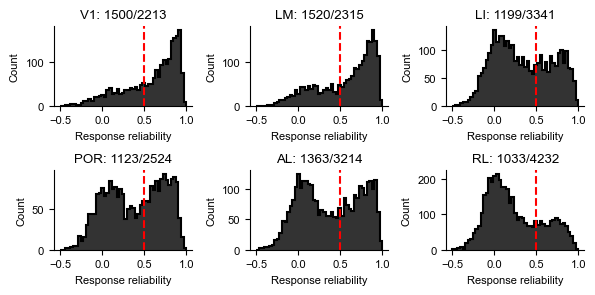

In [11]:
fig31 = plot_noise_ceiling(reliability, regions, figsize=(6,3))
if save: fig31[0].savefig(os.path.join(savepath, 'response_reliability_stratified.pdf'))

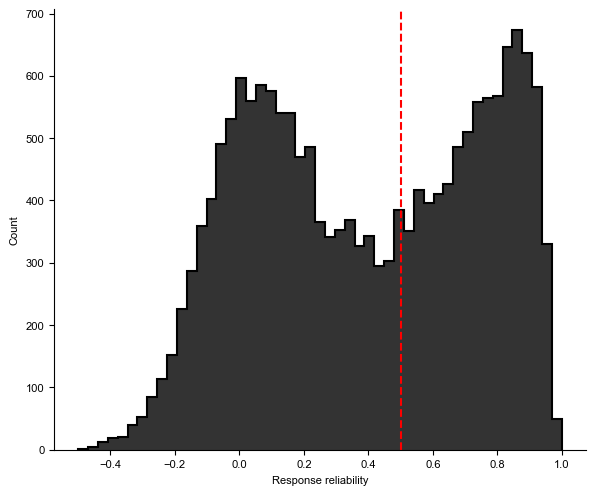

In [12]:
fig32 = plot_noise_ceiling_pooled(reliability, regions)
if save: fig32[0].savefig(os.path.join(savepath, 'response_reliability.pdf'))

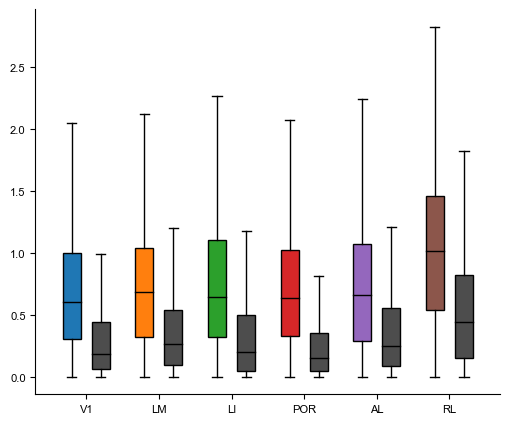

In [13]:
fig41 = plot_prediction(predictions, predictions0, noise_ceilings, regions, normalise=True, figsize=(6,5))
if save: fig41[0].savefig(os.path.join(savepath, 'model_performance_box.pdf'))

MannwhitneyuResult(statistic=1000000.0, pvalue=0.0)
MannwhitneyuResult(statistic=1000000.0, pvalue=0.0)
MannwhitneyuResult(statistic=1000000.0, pvalue=0.0)
MannwhitneyuResult(statistic=1000000.0, pvalue=0.0)
MannwhitneyuResult(statistic=1000000.0, pvalue=0.0)
MannwhitneyuResult(statistic=1000000.0, pvalue=0.0)


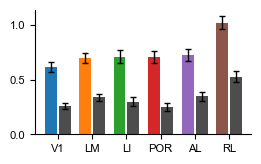

In [14]:
fig42 = plot_prediction_bar(explained_var, explained_var0, regions, figsize=(2.655, 1.683))
fig42[0].tight_layout()
if save: fig42[0].savefig(os.path.join(savepath, 'model_performance_bar.eps'))

# Run stats
for i in range(len(regions)):
    print(mannwhitneyu(explained_var[i], explained_var0[i]))

## 3. Example experiment

In [15]:
# Plotting functions
def plot_confusion(conf_matrix, figsize=(6,5)):
    '''Plot the confusion matrix of validation experiment'''
    fig, ax = pl.subplots(figsize=figsize)
    im = ax.imshow(conf_matrix, vmin=0, vmax=5, cmap='gray')
    # ax.set_xlabel('Neuron ID')
    # ax.set_ylabel('Optimal image ID')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, ticks=[0, 2, 4], label='')
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)
    return fig, ax

def plot_normalised_boxplot(all_stim, opt_stim, figsize=(6,5)):
    '''Plot the distribution of normalised responses'''
    c = ['r', [.3]*3]
    fig, ax = pl.subplots(figsize=figsize)
    data = [opt_stim, all_stim.ravel()]
    bp = ax.boxplot(data, showfliers=False, patch_artist=True, medianprops=dict(color='k'), widths=0.6)
    for patch, color in zip(bp['boxes'], c):
        patch.set_facecolor(color)
    ax.set_xticklabels(['OptStim', 'NatStim'])
    ax.set_ylabel('z-score')

    return fig, ax

def get_percentile(opt_stim, all_stim):
    '''Convert opt_stim to percentile'''
    percentile = np.array([(all_stim[:,i] <= opt_stim[i]).sum()/all_stim.shape[0] for i in range(opt_stim.shape[0])])
    return percentile

def plot_percentile(percentile, all_stim, opt_stim, figsize=(6,5)):
    fig, ax = pl.subplots(figsize=figsize)
    ax.hist(percentile, bins=np.linspace(0,1,50), color=[.3]*3)
    ax.hist(percentile, bins=np.linspace(0,1,50), color=[0]*3, histtype='step', linewidth=.5)
    # ax.set_xlabel('Response percentile')
    # ax.set_ylabel('Count')

    c = ['r', [.3]*3]
    axins = inset_axes(ax, width='60%', height='40%', bbox_to_anchor=(.2, .5, .4, .9), bbox_transform=(ax.transAxes), loc=3)
    data = [opt_stim, all_stim.ravel()]
    bp = axins.boxplot(data, showfliers=False, patch_artist=True, medianprops=dict(color='k'), widths=0.6)
    for patch, color in zip(bp['boxes'], c):
        patch.set_facecolor(color)
    axins.set_xticklabels(['O', 'N'])
    # axins.set_ylabel('z-score')
    axins.set_yticks([0,5,10])
    axins.spines['top'].set_visible(False)
    axins.spines['right'].set_visible(False)

    return fig, ax, axins

def plot_traces(traces, N=10, figsize=(6,5)):
    '''Plot example traces'''
    fig, axes = pl.subplots(ncols=N, nrows=N, figsize=figsize)
    for i in range(N):
        for j in range(N):
            if i == j: c = 'r'
            else: c = 'k'
            axes[i,j].plot(gaussian_filter(traces[i,j],.75), color=c, ls='-', marker='', lw=2)
            axes[i,j].set_ylim(-2,8)
            axes[i,j].axis('off')
    return fig, axes


In [16]:
# Filepath to data
fp_example = r'D:\Data\DeepMouse\Processed\RT113_V1-1\results-RT113-V1-20230630.npy'
fp_example_traces = r'D:\Data\DeepMouse\Processed\RT113_V1-1\example_results.npy'
fp_example_ims = r'F:\DeepMouse\RT_113\V1\20230630\d1\experiments\Model\V1_shallowConv_4_untrained_e2e_16_optimal_stimuli\optStim'

# Load data and unpack
example_results = np.load(fp_example, allow_pickle=True).item()
noise_ceiling = example_results['nc'] > 0.3
example_mask = example_results['mask'] * noise_ceiling

umask = example_results['umask'][example_mask][:,example_mask]
all_stim = example_results['all_stim'][:,example_mask]
scaler = StandardScaler()
scaler.fit(np.vstack([umask, all_stim]))
umask = scaler.transform(umask)
all_stim = scaler.transform(all_stim)

umask_percentile = get_percentile(np.diagonal(umask), all_stim)

traces = np.load(fp_example_traces)[example_mask][:,example_mask]
traces = StandardScaler().fit_transform(traces.reshape(traces.shape[0], -1)).reshape(traces.shape)
idx = np.argsort(np.diagonal(umask))[::-1]
filt = umask_percentile > 0.99
traces = traces[idx[filt]][:,idx[filt]]


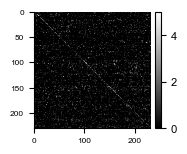

In [17]:
fig5 = plot_confusion(umask, figsize=(1.665*1.1,1.451*1.1))
fig5[0].tight_layout()
if save: fig5[0].savefig(os.path.join(savepath, 'example_confusion_matrix.eps'), dpi=600)

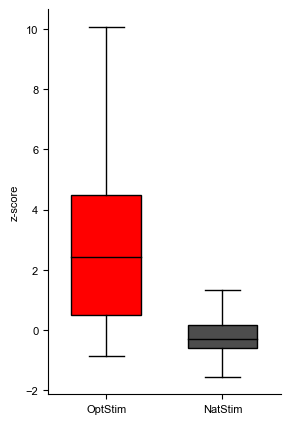

In [18]:
fig6 = plot_normalised_boxplot(all_stim, np.diagonal(umask), figsize=(3,5))
if save: fig6[0].savefig(os.path.join(savepath, 'example_normalised_boxplot.pdf'))

MannwhitneyuResult(statistic=1692705.0, pvalue=1.4022174455974192e-85)


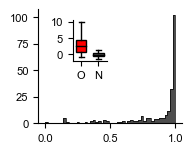

In [19]:
fig7 = plot_percentile(umask_percentile, all_stim, np.diagonal(umask), figsize=(1.85,1.478))
# fig7[0].tight_layout()
if save: fig7[0].savefig(os.path.join(savepath, 'example_percentile.eps'),bbox_inches="tight")
print(mannwhitneyu(np.concatenate(all_stim), np.diagonal(umask)))

In [20]:
print(umask_percentile.shape)

(231,)


In [21]:
# N = 10
# fig8 = plot_traces(traces, N=N, figsize=(5,5))
# if save: fig8[0].savefig(os.path.join(savepath, 'example_traces.pdf'))
# # Load optimal images
# ims = [pl.imsave(os.path.join(savepath, f'example_{n}.png'), pl.imread(os.path.join(fp_example_ims, f"{i}.png"))) for n,i in enumerate(idx[filt][:N])]

## 4. Validation summary

In [22]:
# Plotting functions
def plot_validation(data_raw, region, figsize=(10,5)):
    '''Plot validation as histograms + boxplot inset'''
    fig, axes = pl.subplots(ncols=3, nrows=2, figsize=figsize)

    for i, ax in enumerate(axes.reshape(-1)):
        percentile, opt_stim, all_stim = data_raw[i]
        ax.hist(percentile, bins=np.linspace(0,1,50), color=colors[i])
        ax.hist(percentile, bins=np.linspace(0,1,50), color=np.array(colors[i])*np.array([0.8,0.8,0.8,1]), histtype='step', linewidth=.5)
        # if i>2: ax.set_xlabel('Response percentile')
        # if i%3 == 0: ax.set_ylabel('Count')
        ax.set_xticks([0,0.5,1])
        ax.set_title(regions[i])

        c = [colors[i], [.3]*3]
        axins = inset_axes(ax, width='60%', height='40%', bbox_to_anchor=(.2, .52, .4, .9), bbox_transform=(ax.transAxes), loc=3)
        data = [opt_stim, all_stim.ravel()]
        bp = axins.boxplot(data, showfliers=False, patch_artist=True, medianprops=dict(color='k'), widths=0.6)
        for patch, color in zip(bp['boxes'], c):
            patch.set_facecolor(color)
        axins.set_xticklabels(['P', 'N'])
        #axins.set_ylabel('Response (norm.)')
        axins.set_yticks([0,5,10])
        #axins.set_yticklabels(['']*3)
        axins.spines['top'].set_visible(False)
        axins.spines['right'].set_visible(False)
        print(f"{region[i]}: {mannwhitneyu(opt_stim, all_stim.ravel())}")

    fig.tight_layout()
    return fig, axes
    

In [23]:
# Filepath to data
fp_validation = r'D:\Data\DeepMouse\Results\validation'
data_validation = [load_validation(fp_validation, region=region) for region in regions]

In [24]:
for i in data_validation:
    print(i[0].shape)

print(np.median(np.concatenate([i[0] for i in data_validation])))
print(np.mean([(i[0] > 0.95).sum()/i[0].shape[0] for i in data_validation]))


(364,)
(351,)
(129,)
(80,)
(126,)
(105,)
0.9162257495590829
0.3680730857571943


V1: MannwhitneyuResult(statistic=30423472.0, pvalue=4.0086416675560785e-121)
LM: MannwhitneyuResult(statistic=94397873.5, pvalue=2.6396299546924307e-80)
LI: MannwhitneyuResult(statistic=5701812.0, pvalue=2.346378412722097e-15)
POR: MannwhitneyuResult(statistic=2309883.0, pvalue=2.120511645598259e-17)
AL: MannwhitneyuResult(statistic=8985708.0, pvalue=1.1508397042549857e-28)
RL: MannwhitneyuResult(statistic=2264583.0, pvalue=5.968517864671555e-11)


c:\Users\rudit\anaconda3\envs\mnp_torch\lib\site-packages\ipykernel_launcher.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


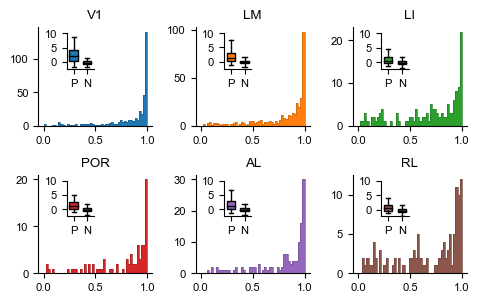

In [25]:
fig9 = plot_validation(data_validation, regions, figsize=(4.837,3.073))
if save: fig9[0].savefig(os.path.join(savepath, 'validation_percentile.eps'))

## 5. Some example raw traces

In [26]:
fp_raw = r'F:\DeepMouse\RT_113\V1\20230630\d1\experiments\suite2p\plane0'
fp_ttl = r'F:\DeepMouse\RT_113\V1\20230630\d1\experiments\d1_186_000\d1_186_000.mat'
F = np.load(os.path.join(fp_raw, 'F.npy'))
Fneu = np.load(os.path.join(fp_raw, 'Fneu.npy'))
iscell = np.load(os.path.join(fp_raw, 'iscell.npy'))
raw = (F-0.7*Fneu)[iscell[:,0]==1]

from scipy.io import loadmat
ttl = np.squeeze(loadmat(fp_ttl)['info']['frame'].item())

# Find ttl around 2500
start = ttl[np.argmin(np.abs(ttl-2450))]
end = ttl[np.argmin(np.abs(ttl-2450))+21]
starts = ttl[np.argmin(np.abs(ttl-2450)):np.argmin(np.abs(ttl-2450))+21:2]
starts = starts-starts[0]
cell_ids = [1, 3, 17, 9]

raw_traces = raw[cell_ids, start:end]
raw_traces = np.array([gaussian_filter(t, sigma=.75) for t in raw_traces])

np.save(os.path.join(savepath, 'raw_traces.npy'), raw_traces)
np.save(os.path.join(savepath, 'raw_traces_ttls.npy'), starts)
raw_traces = MinMaxScaler().fit_transform(raw_traces.T).T
raw_traces = raw_traces + (np.arange(raw_traces.shape[0])+1)[:,None]
pl.plot(raw_traces.T)
pl.xlabel('Frames')
for i in starts:
    pl.axvline(i, ls='--', color=[.5]*3)
print()

FileNotFoundError: [Errno 2] No such file or directory: 'F:\\DeepMouse\\RT_113\\V1\\20230630\\d1\\experiments\\suite2p\\plane0\\F.npy'